In [1]:
import numpy as np
import pandas as pd

# Path to your binary file
file_path = '/content/drive/MyDrive/SDC_CSV/16psk.csv'  # Update this with the actual path to your file if needed

try:
    # Read the file as binary
    with open(file_path, 'rb') as file:
        binary_content = file.read()

    # Interpret the binary data as 32-bit floating-point numbers
    float_values = np.frombuffer(binary_content, dtype=np.float32)

    # Create a DataFrame and add a new feature column named '16psk'
    data = pd.DataFrame({'values': float_values})
    data['16psk'] = '16psk'  # Add the new column with "16psk" as the value for all rows

    # Truncate to 40,000 rows
    truncated_data = data.head(40000)

    # Save the DataFrame to a new CSV file
    output_file = 'converted_data_with_16psk'
    truncated_data.to_csv(output_file, index=False)
    print(f"Truncated data with 'bpsk' feature saved to '{output_file}'.")

except Exception as e:
    print("Error:", e)


Truncated data with 'bpsk' feature saved to 'converted_data_with_16psk'.


In [2]:
import numpy as np
import pandas as pd

# Path to your binary file
file_path = '/content/drive/MyDrive/SDC_CSV/fsk_demod.csv'  # Update this with the actual path to your file if needed

try:
    # Read the file as binary
    with open(file_path, 'rb') as file:
        binary_content = file.read()

    # Ensure the buffer size is a multiple of 4 bytes
    buffer_size = len(binary_content)
    valid_size = buffer_size - (buffer_size % 4)
    trimmed_content = binary_content[:valid_size]

    # Interpret the binary data as 32-bit floating-point numbers
    float_values = np.frombuffer(trimmed_content, dtype=np.float32)

    # Create a DataFrame and add a new feature column named 'fsk'
    data = pd.DataFrame({'values': float_values})
    data['fsk'] = 'fsk'  # Add the new column with "fsk" as the value for all rows

    # Truncate to 40,000 rows
    truncated_data = data.head(40000)

    # Save the DataFrame to a new CSV file
    output_file = 'converted_data_with_fsk.csv'
    truncated_data.to_csv(output_file, index=False)
    print(f"Truncated data with 'fsk' feature saved to '{output_file}'.")

except Exception as e:
    print("Error:", e)


Truncated data with 'fsk' feature saved to 'converted_data_with_fsk.csv'.


In [3]:
import pandas as pd
import numpy as np

try:
    # Paths to the converted CSV files
    psk16_file = '/content/converted_data_with_16psk'
    fsk_file = '/content/converted_data_with_fsk.csv'

    # Output merged file path
    output_file = 'merged_data_randomized.csv'

    # Load the 16PSK and FSK datasets
    psk16_data = pd.read_csv(psk16_file)
    fsk_data = pd.read_csv(fsk_file)

    # Add a new column to indicate the source type
    psk16_data['signal_type'] = '16psk'
    fsk_data['signal_type'] = 'fsk'

    # Extract only the 'values' column and add the source type as 'signal_type'
    psk16_values = psk16_data[['values', 'signal_type']]
    fsk_values = fsk_data[['values', 'signal_type']]

    # Combine the datasets
    combined_data = pd.concat([psk16_values, fsk_values], ignore_index=True)

    # Randomly shuffle the 'values' column
    combined_data_shuffled = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the merged and randomized data to a new CSV file
    combined_data_shuffled.to_csv(output_file, index=False)
    print(f"Merged and randomized data saved to '{output_file}'.")

except Exception as e:
    print("Error:", e)


Merged and randomized data saved to 'merged_data_randomized.csv'.


In [4]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Load the dataset
data_file = '/content/merged_data_randomized.csv'
data = pd.read_csv(data_file)

# Display missing value counts before handling
print("Missing values before handling:")
print(data.isnull().sum())

# Handle missing values
# For numerical columns, replace missing values with the mean
numerical_cols = data.select_dtypes(include=['number']).columns
imputer_num = SimpleImputer(strategy='mean')
data[numerical_cols] = imputer_num.fit_transform(data[numerical_cols])

# For categorical columns, replace missing values with the most frequent value (mode)
categorical_cols = data.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = imputer_cat.fit_transform(data[categorical_cols])

# Verify missing values are handled
print("\nMissing values after handling:")
print(data.isnull().sum())

# Save the processed data to a new CSV file
output_file = '/content/processed_data.csv'
data.to_csv(output_file, index=False)
print(f"\nProcessed data saved to {output_file}")


Missing values before handling:
values         350
signal_type      0
dtype: int64

Missing values after handling:
values         0
signal_type    0
dtype: int64

Processed data saved to /content/processed_data.csv


SVM Accuracy: 0.5034583333333333
Random Forest Accuracy: 0.5456666666666666
Logistic Regression Accuracy: 0.504875


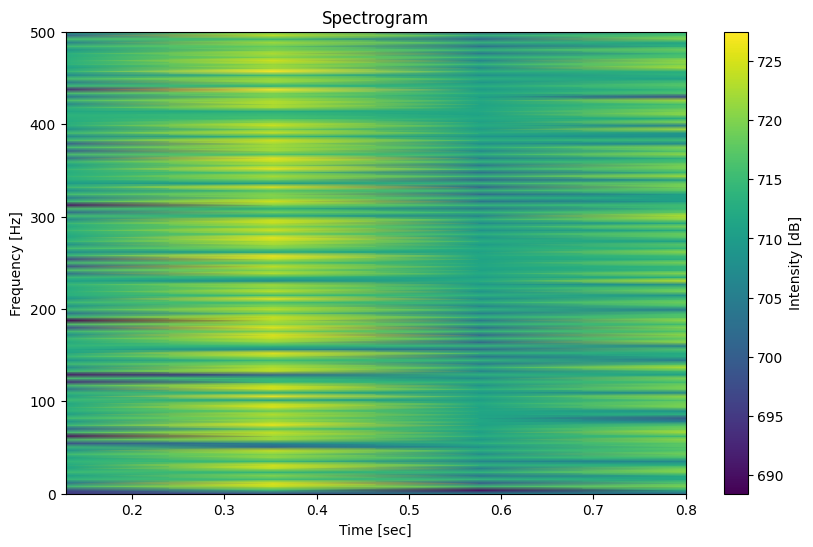

Voting Classifier Accuracy: 0.504875


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy.signal import spectrogram

# Load the merged data
data_file = '/content/processed_data.csv'
data = pd.read_csv(data_file)

# Handle missing values in the 'values' column
imputer = SimpleImputer(strategy='mean')
data['values'] = imputer.fit_transform(data[['values']])

# Encode the 'signal_type' column (16PSK and FSK) into numeric labels
label_encoder = LabelEncoder()
data['signal_type_encoded'] = label_encoder.fit_transform(data['signal_type'])

# Separate features (values) and target (signal_type_encoded)
X = data[['values']].values
y = data['signal_type_encoded'].values

# Standardize the feature column
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Classifier - SVM
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
svm_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

# Classifier - Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

# Classifier - Logistic Regression
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train, y_train)
lr_pred = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

# Print classification results
print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)

# Spectrogram Generation (for a random selection of signal data)
def generate_spectrogram(signal, fs=1000):
    f, t, Sxx = spectrogram(signal, fs)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

# Choose a random row to generate a spectrogram
random_signal = data['values'].iloc[1000:2000].values  # Adjust the range based on the size of your data
generate_spectrogram(random_signal)

# Voting Classifier
voting_clf = VotingClassifier(estimators=[('svm', svm_classifier),
                                          ('rf', rf_classifier),
                                          ('lr', lr_classifier)], voting='hard')
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
print("Voting Classifier Accuracy:", voting_accuracy)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:30:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SVM Accuracy: 0.5034583333333333
Random Forest Accuracy: 0.5456666666666666
Logistic Regression Accuracy: 0.504875
Gradient Boosting Accuracy: 0.54425
K-Nearest Neighbors Accuracy: 0.602875
XGBoost Accuracy: 0.563


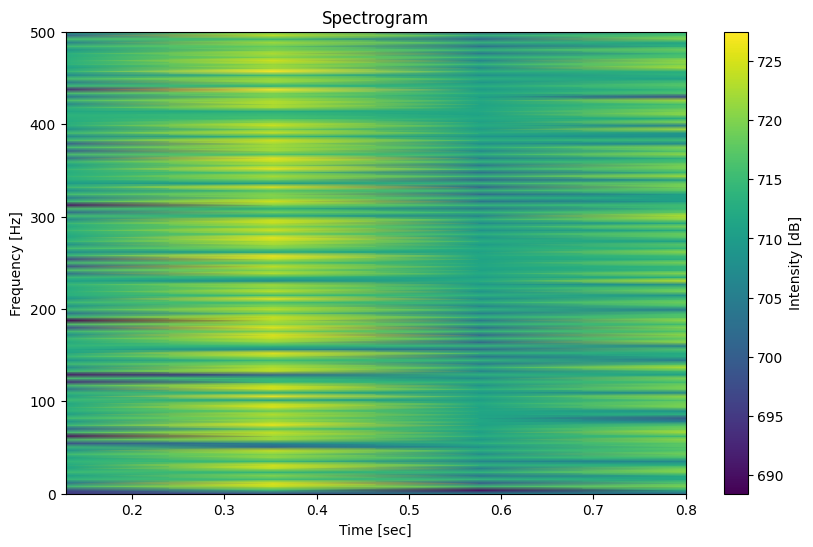

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:31:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Classifier Accuracy: 0.54425


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy.signal import spectrogram

# Load the merged data
data_file = '/content/processed_data.csv'
data = pd.read_csv(data_file)

# Handle missing values in the 'values' column
imputer = SimpleImputer(strategy='mean')
data['values'] = imputer.fit_transform(data[['values']])

# Encode the 'signal_type' column (16PSK and FSK) into numeric labels
label_encoder = LabelEncoder()
data['signal_type_encoded'] = label_encoder.fit_transform(data['signal_type'])

# Separate features (values) and target (signal_type_encoded)
X = data[['values']].values
y = data['signal_type_encoded'].values

# Standardize the feature column
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Classifier - SVM
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
svm_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

# Classifier - Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

# Classifier - Logistic Regression
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train, y_train)
lr_pred = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

# Classifier - Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
gb_pred = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

# Classifier - K-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_pred = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)

# Classifier - XGBoost
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train, y_train)
xgb_pred = xgb_classifier.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

# Print classification results
print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Gradient Boosting Accuracy:", gb_accuracy)
print("K-Nearest Neighbors Accuracy:", knn_accuracy)
print("XGBoost Accuracy:", xgb_accuracy)

# Spectrogram Generation (for a random selection of signal data)
def generate_spectrogram(signal, fs=1000):
    f, t, Sxx = spectrogram(signal, fs)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

# Choose a random row to generate a spectrogram
random_signal = data['values'].iloc[1000:2000].values  # Adjust the range based on the size of your data
generate_spectrogram(random_signal)

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('rf', rf_classifier),
    ('lr', lr_classifier),
    ('gb', gb_classifier),
    ('knn', knn_classifier),
    ('xgb', xgb_classifier)
], voting='hard')
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
print("Voting Classifier Accuracy:", voting_accuracy)


In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Load the data
data_file = '/content/merged_data_randomized.csv'  # Replace with your input file path
data = pd.read_csv(data_file)

# Display initial information about the data
print("Initial data preview:")
print(data.head())
print("\nMissing values per column:")
print(data.isnull().sum())

# Separate numeric and non-numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns
non_numeric_columns = data.select_dtypes(exclude=['number']).columns

# Handle missing values for numeric data by replacing them with the mean
imputer = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# For non-numeric data, fill missing values with a placeholder (e.g., 'Unknown')
data[non_numeric_columns] = data[non_numeric_columns].fillna('Unknown')

# Save the processed data to a new CSV file
output_file = 'output_file.csv'  # Replace with your desired output file path
data.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")


Initial data preview:
         values signal_type
0 -6.291222e+35         fsk
1 -4.591487e+20         fsk
2  4.972890e-01         fsk
3  2.959324e+01         fsk
4 -5.142817e-07         fsk

Missing values per column:
values         350
signal_type      0
dtype: int64
Processed data saved to output_file.csv


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:40:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SVM Accuracy: 0.5034583333333333
Random Forest Accuracy: 0.5456666666666666
Logistic Regression Accuracy: 0.504875
Gradient Boosting Accuracy: 0.54425
K-Nearest Neighbors Accuracy: 0.602875
XGBoost Accuracy: 0.563


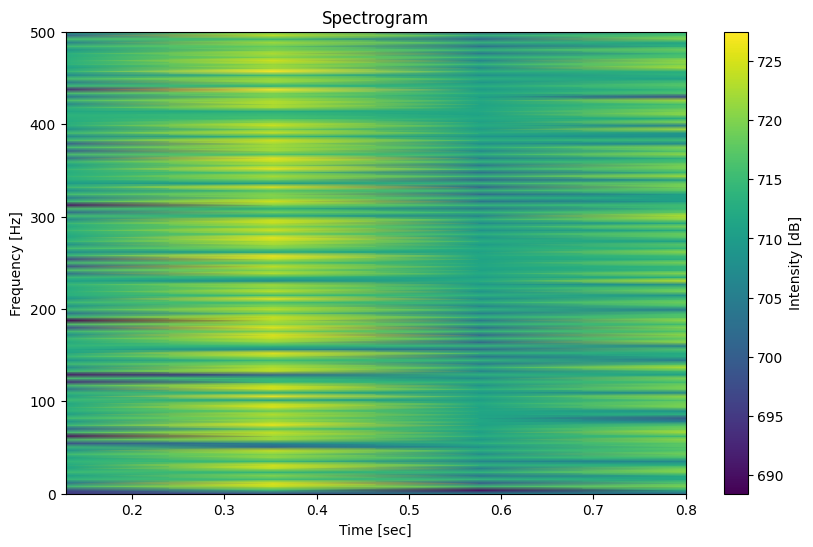

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:41:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Classifier Accuracy: 0.54425


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy.signal import spectrogram

# Load the merged data
data_file = '/content/output_file.csv'
data = pd.read_csv(data_file)

# Handle missing values in the 'values' column
imputer = SimpleImputer(strategy='mean')
data['values'] = imputer.fit_transform(data[['values']])

# Encode the 'signal_type' column (16PSK and FSK) into numeric labels
label_encoder = LabelEncoder()
data['signal_type_encoded'] = label_encoder.fit_transform(data['signal_type'])

# Separate features (values) and target (signal_type_encoded)
X = data[['values']].values
y = data['signal_type_encoded'].values

# Standardize the feature column
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Classifier - SVM
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
svm_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

# Classifier - Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

# Classifier - Logistic Regression
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train, y_train)
lr_pred = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

# Classifier - Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
gb_pred = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

# Classifier - K-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_pred = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)

# Classifier - XGBoost
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train, y_train)
xgb_pred = xgb_classifier.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

# Print classification results
print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Gradient Boosting Accuracy:", gb_accuracy)
print("K-Nearest Neighbors Accuracy:", knn_accuracy)
print("XGBoost Accuracy:", xgb_accuracy)

# Spectrogram Generation (for a random selection of signal data)
def generate_spectrogram(signal, fs=1000):
    f, t, Sxx = spectrogram(signal, fs)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

# Choose a random row to generate a spectrogram
random_signal = data['values'].iloc[1000:2000].values  # Adjust the range based on the size of your data
generate_spectrogram(random_signal)

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('rf', rf_classifier),
    ('lr', lr_classifier),
    ('gb', gb_classifier),
    ('knn', knn_classifier),
    ('xgb', xgb_classifier)
], voting='hard')
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
print("Voting Classifier Accuracy:", voting_accuracy)


SVM Accuracy: 0.5035
SVM Classification Report:
              precision    recall  f1-score   support

       16psk       0.50      1.00      0.67     11880
         fsk       1.00      0.02      0.03     12120

    accuracy                           0.50     24000
   macro avg       0.75      0.51      0.35     24000
weighted avg       0.75      0.50      0.35     24000


Random Forest Accuracy: 0.5457
Random Forest Classification Report:
              precision    recall  f1-score   support

       16psk       0.52      1.00      0.69     11880
         fsk       1.00      0.10      0.18     12120

    accuracy                           0.55     24000
   macro avg       0.76      0.55      0.43     24000
weighted avg       0.76      0.55      0.43     24000


Logistic Regression Accuracy: 0.5049
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       16psk       0.50      1.00      0.67     11880
         fsk       1.00      0.02      

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:44:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.5630
XGBoost Classification Report:
              precision    recall  f1-score   support

       16psk       0.53      1.00      0.69     11880
         fsk       1.00      0.13      0.24     12120

    accuracy                           0.56     24000
   macro avg       0.77      0.57      0.47     24000
weighted avg       0.77      0.56      0.46     24000


Decision Tree Accuracy: 0.5443
Decision Tree Classification Report:
              precision    recall  f1-score   support

       16psk       0.52      1.00      0.68     11880
         fsk       1.00      0.10      0.18     12120

    accuracy                           0.54     24000
   macro avg       0.76      0.55      0.43     24000
weighted avg       0.76      0.54      0.43     24000




/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.5443
AdaBoost Classification Report:
              precision    recall  f1-score   support

       16psk       0.52      1.00      0.68     11880
         fsk       1.00      0.10      0.18     12120

    accuracy                           0.54     24000
   macro avg       0.76      0.55      0.43     24000
weighted avg       0.76      0.54      0.43     24000




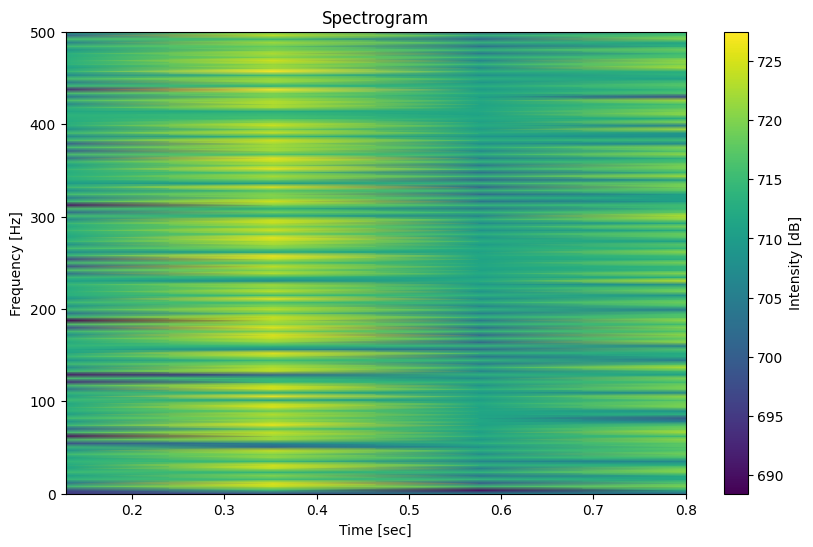

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:45:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Voting Classifier Accuracy: 0.5443
Voting Classifier Classification Report:
              precision    recall  f1-score   support

       16psk       0.52      1.00      0.68     11880
         fsk       1.00      0.10      0.18     12120

    accuracy                           0.54     24000
   macro avg       0.76      0.55      0.43     24000
weighted avg       0.76      0.54      0.43     24000




In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy.signal import spectrogram

# Load the merged data
data_file = '/content/processed_data.csv'
data = pd.read_csv(data_file)

# Handle missing values in the 'values' column
imputer = SimpleImputer(strategy='mean')
data['values'] = imputer.fit_transform(data[['values']])

# Encode the 'signal_type' column (16PSK and FSK) into numeric labels
label_encoder = LabelEncoder()
data['signal_type_encoded'] = label_encoder.fit_transform(data['signal_type'])

# Separate features (values) and target (signal_type_encoded)
X = data[['values']].values
y = data['signal_type_encoded'].values

# Standardize the feature column
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define and evaluate multiple classifiers
classifiers = {
    'SVM': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Classification Report:\n{report}\n")

    # Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('svm', classifiers['SVM']),
    ('rf', classifiers['Random Forest']),
    ('lr', classifiers['Logistic Regression']),
    ('gb', classifiers['Gradient Boosting']),
    ('knn', classifiers['K-Nearest Neighbors']),
    ('xgb', classifiers['XGBoost']),
    ('dt', classifiers['Decision Tree']),
    ('ada', classifiers['AdaBoost'])
], voting='hard')
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_pred)
voting_report = classification_report(y_test, voting_pred, target_names=label_encoder.classes_)

print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")
print(f"Voting Classifier Classification Report:\n{voting_report}\n")


# Spectrogram Generation (for a random selection of signal data)
def generate_spectrogram(signal, fs=1000):
    f, t, Sxx = spectrogram(signal, fs)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

# Choose a random row to generate a spectrogram
random_signal = data['values'].iloc[1000:2000].values  # Adjust the range based on the size of your data
generate_spectrogram(random_signal)

